Restarted rv (Python 3.11.9)

In [1]:
import os
import sys
from datetime import datetime
from typing import Any, Optional, Tuple, Union, Sequence, Dict, Iterator, Literal, List
from shapely.geometry import Polygon

import multiprocessing
# multiprocessing.set_start_method('fork')
import cv2
import pytorch_lightning as pl
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import torch
from rastervision.core.box import Box
import rasterio
from affine import Affine
from pyproj import Transformer
from rasterio.transform import rowcol, xy
from rasterio.features import rasterize
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from typing import TYPE_CHECKING
import wandb
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter
from torch.utils.data import ConcatDataset

from fvcore.nn import FlopCountAnalysis
# from torchinfo import summary  # Optional, for detailed summary

from typing import Self
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from collections import OrderedDict
import duckdb


# Project-specific imports
current_dir = os.path.dirname(os.path.abspath(__file__))
parent_dir = os.path.dirname(current_dir)
grandparent_dir = os.path.dirname(parent_dir)
sys.path.append(grandparent_dir)
sys.path.append(parent_dir)

from src.models.model_definitions import MultiModalPredictionsIterator, CustomGeoJSONVectorSource, CustomVectorOutputConfig, MergeDataset
from deeplnafrica.deepLNAfrica import (Deeplabv3SegmentationModel, init_segm_model, 
                                       CustomDeeplabv3SegmentationModel)
from src.data.dataloaders import (create_sentinel_raster_source, create_buildings_raster_source,
                                  create_datasets, show_windows, CustomStatsTransformer,
                                  CustomSemanticSegmentationSlidingWindowGeoDataset)
from rastervision.core.data.label import SemanticSegmentationLabels
from rastervision.pytorch_learner import SemanticSegmentationVisualizer
from rastervision.core.data import (Scene, ClassConfig, RasterioCRSTransformer,
                                    RasterioSource, GeoJSONVectorSource,
                                    ClassInferenceTransformer, RasterizedSource,
                                    SemanticSegmentationLabelSource, VectorSource)
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from rastervision.core.raster_stats import RasterStats
from rastervision.core.data.raster_transformer import RasterTransformer
from rastervision.core.data.utils import listify_uris, merge_geojsons
from rastervision.pipeline.file_system import (
    get_local_path, json_to_file, make_dir, sync_to_dir, file_exists,
    download_if_needed, NotReadableError, get_tmp_dir)
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from rastervision.pytorch_learner.dataset.visualizer import Visualizer  # NOQA
from rastervision.pytorch_learner.utils import (
    color_to_triple, plot_channel_groups, channel_groups_to_imgs)

from typing import (TYPE_CHECKING, Sequence, Optional, List, Dict, Union,
                    Tuple, Any)
from abc import ABC, abstractmethod

from torch import Tensor
import albumentations as A

from rastervision.pipeline.file_system import make_dir
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner.utils import (
    deserialize_albumentation_transform, validate_albumentation_transform,
    MinMaxNormalize)
from rastervision.pytorch_learner.learner_config import (
    RGBTuple,
    ChannelInds,
    validate_channel_display_groups,
    get_default_channel_display_groups,
)

if TYPE_CHECKING:
    from torch.utils.data import Dataset
    from matplotlib.figure import Figure

from typing import TYPE_CHECKING, Iterator, List, Optional
from os.path import join

from rastervision.pipeline.config import register_config, Config, Field
from rastervision.core.data.label_store import (LabelStoreConfig,
                                                SemanticSegmentationLabelStore)
from rastervision.core.data.utils import (denoise, mask_to_building_polygons,
                                          mask_to_polygons)

if TYPE_CHECKING:
    import numpy as np
    from shapely.geometry.base import BaseGeometry

    from rastervision.core.box import Box
    from rastervision.core.data import (ClassConfig, CRSTransformer,
                                        SceneConfig)
    from rastervision.core.rv_pipeline import RVPipelineConfig
    

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available.")
else:
    device = torch.device("mps")
    print("MPS is available.")

label_uri = "../../data/0/SantoDomingo3857.geojson"
image_uri = '../../data/0/sentinel_Gee/DOM_Los_Minas_2024.tif'
buildings_uri = '../../data/0/overture/santodomingo_buildings.geojson'

label_uriGC = "../../data/SHP/Guatemala_PS.shp"
image_uriGC = '../../data/0/sentinel_Gee/GTM_Chimaltenango_2023.tif'
buildings_uriGC = '../../data/0/overture/GT_buildings3857.geojson'

label_uriTG = "../../data/SHP/Tegucigalpa_PS.shp"
image_uriTG = '../../data/0/sentinel_Gee/HND_Comayaguela_2023.tif'
buildings_uriTG = '../../data/0/overture/HND_buildings3857.geojson'

label_uriPN = "../../data/SHP/Panama_PS.shp"
image_uriPN = '../../data/0/sentinel_Gee/PAN_San_Miguelito_2023.tif'
buildings_uriPN = '../../data/0/overture/PN_buildings3857.geojson'

class_config = ClassConfig(names=['background', 'slums'], 
                                colors=['lightgray', 'darkred'],
                                null_class='background')

# Santo Domingo
sentinel_source_normalizedSD, sentinel_label_raster_sourceSD = create_sentinel_raster_source(image_uri, label_uri, class_config, clip_to_label_source=True)
rasterized_buildings_sourceSD, buildings_label_sourceSD, crs_transformer_buildingsSD = create_buildings_raster_source(buildings_uri, image_uri, label_uri, class_config, resolution=5)    

SentinelScene_SD = Scene(
        id='santodomingo_sentinel',
        raster_source = sentinel_source_normalizedSD,
        label_source = sentinel_label_raster_sourceSD)
        # aoi_polygons=[pixel_polygon])

BuildingsScene_SD = Scene(
        id='santodomingo_buildings',
        raster_source = rasterized_buildings_sourceSD,
        label_source = buildings_label_sourceSD)

buildingsGeoDataset_SD, train_buildings_dataset_SD, val_buildings_dataset_SD, test_buildings_dataset_SD = create_datasets(BuildingsScene_SD, imgsize=288, stride=288, padding=50, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset_SD, train_sentinel_dataset_SD, val_sentinel_dataset_SD, test_sentinel_dataset_SD = create_datasets(SentinelScene_SD, imgsize=144, stride=144, padding=25, val_ratio=0.2, test_ratio=0.1, seed=42)

batch_size = 16

train_multiple_cities=True

if train_multiple_cities:
    # Guatemala City
    sentinel_source_normalizedGC, sentinel_label_raster_sourceGC = create_sentinel_raster_source(image_uriGC, label_uriGC, class_config, clip_to_label_source=True)
    rasterized_buildings_sourceGC, buildings_label_sourceGC, crs_transformer_buildingsGC = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriGC, class_config, resolution=5)    

    BuildingsScene_GC = Scene(
            id='GC_buildings',
            raster_source = rasterized_buildings_sourceGC,
            label_source = buildings_label_sourceGC)
            
    SentinelScene_GC = Scene(
            id='GC_sentinel',
            raster_source = sentinel_source_normalizedGC,
            label_source = sentinel_label_raster_sourceGC)

    # # Tegucigalpa
    # sentinel_source_normalizedTG, sentinel_label_raster_sourceTG = create_sentinel_raster_source(image_uriGC, label_uriTG, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourceTG, buildings_label_sourceTG, crs_transformer_buildingsTG = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriTG, class_config, resolution=5)

    # SentinelScene_TG = Scene(
    #     id='TG_sentinel',
    #     raster_source=sentinel_source_normalizedTG,
    #     label_source=sentinel_label_raster_sourceTG)

    # BuildingsScene_TG = Scene(
    #     id='TG_buildings',
    #     raster_source=rasterized_buildings_sourceTG,
    #     label_source=buildings_label_sourceTG)

    # # Panama City
    # sentinel_source_normalizedPN, sentinel_label_raster_sourcePN = create_sentinel_raster_source(image_uriPN, label_uriPN, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourcePN, buildings_label_sourcePN, crs_transformer_buildingsPN = create_buildings_raster_source(buildings_uriPN, image_uriPN, label_uriPN, class_config, resolution=5)

    # SentinelScene_PN = Scene(
    #     id='PN_sentinel',
    #     raster_source=sentinel_source_normalizedPN,
    #     label_source=sentinel_label_raster_sourcePN)

    # BuildingsScene_PN = Scene(
    #     id='PN_buildings',
    #     raster_source=rasterized_buildings_sourcePN,
    #     label_source=buildings_label_sourcePN)
    
    # Guatemala City
    buildingsGeoDataset_GC, _, _, _ = create_datasets(BuildingsScene_GC, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    sentinelGeoDataset_GC, _, _, _ = create_datasets(SentinelScene_GC, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # Tegucigalpa
    # buildingsGeoDataset_TG, train_buildings_dataset_TG, val_buildings_dataset_TG, test_buildings_dataset_TG = create_datasets(BuildingsScene_TG, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_TG, train_sentinel_dataset_TG, val_sentinel_dataset_TG, test_sentinel_dataset_TG = create_datasets(SentinelScene_TG, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # # Panama City
    # buildingsGeoDataset_PN, train_buildings_dataset_PN, val_buildings_dataset_PN, test_buildings_dataset_PN = create_datasets(BuildingsScene_PN, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_PN, train_sentinel_dataset_PN, val_sentinel_dataset_PN, test_sentinel_dataset_PN = create_datasets(SentinelScene_PN, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, buildingsGeoDataset_GC]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
    all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
    all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

    all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, sentinelGeoDataset_GC]) # train_buildings_dataset_TG, train_buildings_dataset_PN
    all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
    all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
        
    train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
    val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

else:
    # when one city for training:
    train_dataset = MergeDataset(train_sentinel_dataset_SD, train_buildings_dataset_SD)
    val_dataset = MergeDataset(val_sentinel_dataset_SD, val_buildings_dataset_SD)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

vis_sent = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_sent)

vis_build = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_build)

x, y = vis_sent.get_batch(sentinelGeoDataset_SD, 2)
vis_sent.plot_batch(x, y, show=True)

x, y = vis_build.get_batch(buildingsGeoDataset_SD, 2)
vis_build.plot_batch(x, y, show=True)

class MultiModalDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def setup(self, stage=None):
        pass

# Initialize the data module
data_module = MultiModalDataModule(train_loader, val_loader)

# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

# for batch_idx, batch in enumerate(data_module.train_dataloader()):
#     # sentinel_batch, buildings_batch = batch
#     # buildings_data, buildings_labels = buildings_batch
#     # sentinel_data, _ = sentinel_batch
#     # sentinel_data = sentinel_data.to(device)
#     # buildings_data = buildings_data.to(device)
#     out = model(batch)
#     print(f"out data shape: {out.shape}")
#     break

output_dir = f'../UNITAC-trained-models/multi_modal/SD_DLV3/'
os.makedirs(output_dir, exist_ok=True)

wandb.init(project='UNITAC-multi-modal', config=hyperparameters)
wandb_logger = WandbLogger(project='UNITAC-multi-modal', log_model=True)

# Loggers and callbacks
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=output_dir,
    filename='multimodal_runid{run_id}-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=50)

# Define trainer
trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
    logger=[wandb_logger],
    min_epochs=20,
    max_epochs=150,
    num_sanity_val_steps=3
)

# Train the model
trainer.fit(model, datamodule=data_module)

# # Use best model for evaluation
# best_model_path_dplv3 = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_DLV3/multimodal_runidrun_id=0-batch_size=00-epoch=01-val_loss=435412992.0000.ckpt"
# best_model_path_fpn = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_FPN/multimodal_runidrun_id=0-epoch=60-val_loss=0.3382.ckpt"
best_model_path_dplv3 = checkpoint_callback.best_model_path
best_model = MultiResolutionDeepLabV3.load_from_checkpoint(best_model_path_dplv3) #MultiResolutionDeepLabV3 MultiResolutionFPN
best_model.eval()

buildingsGeoDataset, train_buildings_dataset, val_buildings_dataset, test_buildings_dataset = create_datasets(BuildingsScene_SD, imgsize=288, stride = 144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset, train_sentinel_dataset, val_sentinel_dataset, test_sentinel_dataset = create_datasets(SentinelScene_SD, imgsize=144, stride = 72, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
predictions_iterator = MultiModalPredictionsIterator(best_model, sentinelGeoDataset, buildingsGeoDataset, device=device)
windows, predictions = zip(*predictions_iterator)

# Ensure windows are Box instances
windows = [Box(*window.tolist()) if isinstance(window, torch.Tensor) else window for window in windows]

# Create SemanticSegmentationLabels from predictions
pred_labels = SemanticSegmentationLabels.from_predictions(
    windows,
    predictions,
    extent=BuildingsScene_SD.extent,
    num_classes=len(class_config),
    smooth=True
)

# Show predictions
scores = pred_labels.get_score_arr(pred_labels.extent)
scores_building = scores[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
image = ax.imshow(scores_building)
ax.axis('off')
ax.set_title('infs Scores')
cbar = fig.colorbar(image, ax=ax)
plt.show()

# Saving predictions as GEOJSON
vector_output_config = CustomVectorOutputConfig(
    class_id=1,
    denoise=8,
    threshold=0.4)

pred_label_store = SemanticSegmentationLabelStore(
    uri='../../vectorised_model_predictions/multi-modal/SD_DLV3/',
    crs_transformer = crs_transformer_buildingsSD,
    class_config = class_config,
    vector_outputs = [vector_output_config],
    discrete_output = True)

pred_label_store.save(pred_labels)

# Vis filters
def visualize_filters(model, layer_name, num_filters=8):
    # Get the layer by name
    layer = dict(model.named_modules())[layer_name]
    assert isinstance(layer, nn.Conv2d), "Layer should be of type nn.Conv2d"

    # Get the weights of the filters
    filters = layer.weight.data.clone().cpu().numpy()

    # Normalize the filters to [0, 1] range for visualization
    min_filter, max_filter = filters.min(), filters.max()
    filters = (filters - min_filter) / (max_filter - min_filter)
    
    # Plot the filters
    num_filters = min(num_filters, filters.shape[0])  # Limit to number of available filters
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 10))
    
    for i, ax in enumerate(axes):
        filter_img = filters[i]
        
        # If the filter has more than one channel, average the channels for visualization
        if filter_img.shape[0] > 1:
            filter_img = np.mean(filter_img, axis=0)
        
        cax = ax.imshow(filter_img, cmap='viridis')
        ax.axis('off')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cax, cax=cbar_ax)

    plt.show()
    
visualize_filters(best_model, 's1_mid', num_filters=8)

best_model.add_hooks()

model.to('mps')
model.add_hooks()

def visualize_feature_maps(model, layer_name, input_data, num_feature_maps=8):
    # Perform a forward pass
    model.eval()
    with torch.no_grad():
        model(input_data)

    # Retrieve the feature maps from the specified layer
    layer = dict(model.named_modules())[layer_name]
    feature_maps = model.feature_maps[layer].cpu().numpy()

    # Plot the feature maps
    num_feature_maps = min(num_feature_maps, feature_maps.shape[1])  # Limit to number of available feature maps
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 10))
    
    for i, ax in enumerate(axes):
        feature_map_img = feature_maps[0, i]
        cax = ax.imshow(feature_map_img, cmap='viridis')
        ax.axis('off')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cax, cax=cbar_ax)

    plt.show()

sentinel_data = torch.randn(1, 4, 144, 144, device='mps')
buildings_data = torch.randn(1, 1, 288, 288, device='mps')
buildings_labels = torch.randn(1, 288, 288, device='mps')

# Form the input batch
input_batch = ((sentinel_data, None), (buildings_data, buildings_labels))

# Visualize feature maps from the first convolutional layer
visualize_feature_maps(model, 's3.0', input_batch, num_feature_maps=8)

# FLOPS
# flops = FlopCountAnalysis(model, batch)

# print(flops.total())
# print(flops.by_module())

# print(parameter_count_table(model))

NameError: name '__file__' is not defined

In [2]:
current_dir = os.path.dirname(os.path.abspath(__file__))

In [3]:
import os
import sys
from datetime import datetime
from typing import Any, Optional, Tuple, Union, Sequence, Dict, Iterator, Literal, List
from shapely.geometry import Polygon

import multiprocessing
# multiprocessing.set_start_method('fork')
import cv2
import pytorch_lightning as pl
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import torch
from rastervision.core.box import Box
import rasterio
from affine import Affine
from pyproj import Transformer
from rasterio.transform import rowcol, xy
from rasterio.features import rasterize
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from typing import TYPE_CHECKING
import wandb
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter
from torch.utils.data import ConcatDataset

from fvcore.nn import FlopCountAnalysis
# from torchinfo import summary  # Optional, for detailed summary

from typing import Self
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from collections import OrderedDict
import duckdb


# Project-specific imports
current_dir = os.path.dirname(os.path.abspath(__file__))

MPS is available.
Loaded SemanticSegmentationLabelSource: (1362, 1620, 1)


Analyzing chips: 0it [00:00, ?it/s]

Loaded Sentinel data of size (1362, 1620, 4), and dtype: float64


Transforming to pixel coords:  16%|#5        | 49682/320286 [00:05<00:27, 9936.31it/s]

Simplifying polygons:  24%|##3       | 76254/320295 [00:05<00:16, 15250.68it/s]

Loaded Rasterised buildings data of size (2722, 3239, 1), and dtype: <class 'numpy.uint8'>
Train dataset length: 71
Validation dataset length: 19
Test (hold-out) dataset length: 9
Train dataset length: 71
Validation dataset length: 19
Test (hold-out) dataset length: 9
Loaded SemanticSegmentationLabelSource: (2402, 2437, 1)


Analyzing chips: 0it [00:00, ?it/s]

Loaded Sentinel data of size (2402, 2437, 4), and dtype: float64


Transforming to pixel coords:   7%|6         | 46609/691411 [00:05<01:09, 9321.78it/s]

Splitting multi-part geoms:  66%|######5   | 456103/691411 [00:05<00:02, 91220.49it/s]

Simplifying polygons:   8%|8         | 55494/691433 [00:05<00:57, 11098.61it/s]

Splitting multi-part geoms:  66%|######5   | 441209/669095 [00:05<00:02, 88241.71it/s]

Loaded Rasterised buildings data of size (4804, 4872, 1), and dtype: <class 'numpy.uint8'>
Train dataset length: 180
Validation dataset length: 51
Test (hold-out) dataset length: 25
Train dataset length: 180
Validation dataset length: 51
Test (hold-out) dataset length: 25


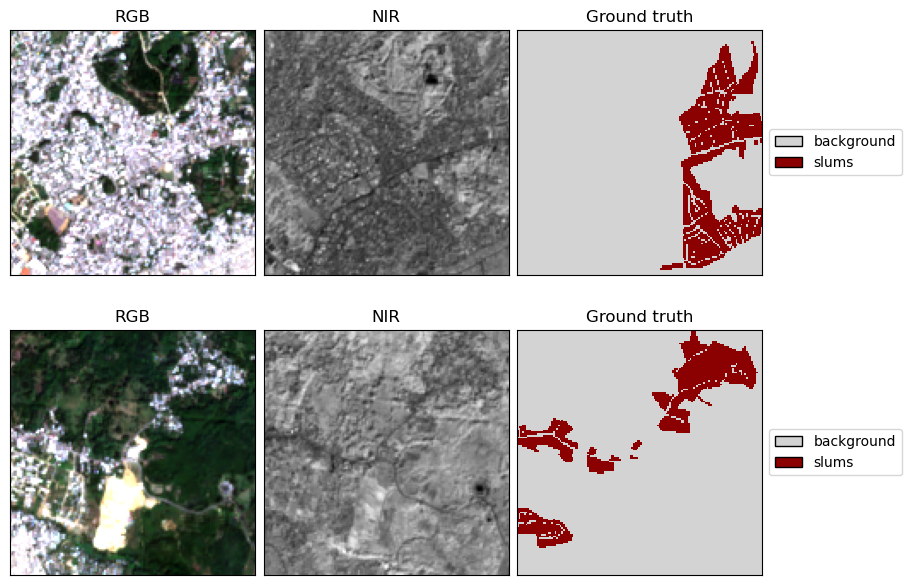

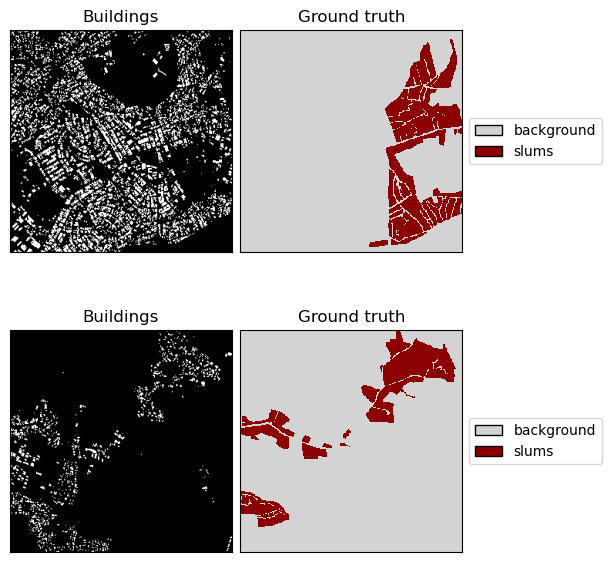

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jankomag. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type                    | Params | Mode 
----------------------------------------------------------------------
0 | encoder           | IntermediateLayerGetter | 23.5 M | train
1 | bconv1            | Conv2d                  | 3.1 K  | train
2 | bconv2            | Conv2d                  | 576    | train
3 | segmentation_head | DeepLabHead             | 16.1 M | train
----------------------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.575   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [1, 288, 288] at entry 0 and [4, 144, 144] at entry 5

In [4]:
import os
import sys
from datetime import datetime
from typing import Any, Optional, Tuple, Union, Sequence, Dict, Iterator, Literal, List
from shapely.geometry import Polygon

import multiprocessing
# multiprocessing.set_start_method('fork')
import cv2
import pytorch_lightning as pl
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import torch
from rastervision.core.box import Box
import rasterio
from affine import Affine
from pyproj import Transformer
from rasterio.transform import rowcol, xy
from rasterio.features import rasterize
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from typing import TYPE_CHECKING
import wandb
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter
from torch.utils.data import ConcatDataset

from fvcore.nn import FlopCountAnalysis
# from torchinfo import summary  # Optional, for detailed summary

from typing import Self
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from collections import OrderedDict
import duckdb


# Project-specific imports
current_dir = os.path.dirname(os.path.abspath(__file__))
parent_dir = os.path.dirname(current_dir)
grandparent_dir = os.path.dirname(parent_dir)
sys.path.append(grandparent_dir)
sys.path.append(parent_dir)

from src.models.model_definitions import MultiModalPredictionsIterator, CustomGeoJSONVectorSource, CustomVectorOutputConfig, MergeDataset
from deeplnafrica.deepLNAfrica import (Deeplabv3SegmentationModel, init_segm_model, 
                                       CustomDeeplabv3SegmentationModel)
from src.data.dataloaders import (create_sentinel_raster_source, create_buildings_raster_source,
                                  create_datasets, show_windows, CustomStatsTransformer,
                                  CustomSemanticSegmentationSlidingWindowGeoDataset)
from rastervision.core.data.label import SemanticSegmentationLabels
from rastervision.pytorch_learner import SemanticSegmentationVisualizer
from rastervision.core.data import (Scene, ClassConfig, RasterioCRSTransformer,
                                    RasterioSource, GeoJSONVectorSource,
                                    ClassInferenceTransformer, RasterizedSource,
                                    SemanticSegmentationLabelSource, VectorSource)
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from rastervision.core.raster_stats import RasterStats
from rastervision.core.data.raster_transformer import RasterTransformer
from rastervision.core.data.utils import listify_uris, merge_geojsons
from rastervision.pipeline.file_system import (
    get_local_path, json_to_file, make_dir, sync_to_dir, file_exists,
    download_if_needed, NotReadableError, get_tmp_dir)
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from rastervision.pytorch_learner.dataset.visualizer import Visualizer  # NOQA
from rastervision.pytorch_learner.utils import (
    color_to_triple, plot_channel_groups, channel_groups_to_imgs)

from typing import (TYPE_CHECKING, Sequence, Optional, List, Dict, Union,
                    Tuple, Any)
from abc import ABC, abstractmethod

from torch import Tensor
import albumentations as A

from rastervision.pipeline.file_system import make_dir
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner.utils import (
    deserialize_albumentation_transform, validate_albumentation_transform,
    MinMaxNormalize)
from rastervision.pytorch_learner.learner_config import (
    RGBTuple,
    ChannelInds,
    validate_channel_display_groups,
    get_default_channel_display_groups,
)

if TYPE_CHECKING:
    from torch.utils.data import Dataset
    from matplotlib.figure import Figure

from typing import TYPE_CHECKING, Iterator, List, Optional
from os.path import join

from rastervision.pipeline.config import register_config, Config, Field
from rastervision.core.data.label_store import (LabelStoreConfig,
                                                SemanticSegmentationLabelStore)
from rastervision.core.data.utils import (denoise, mask_to_building_polygons,
                                          mask_to_polygons)

if TYPE_CHECKING:
    import numpy as np
    from shapely.geometry.base import BaseGeometry

    from rastervision.core.box import Box
    from rastervision.core.data import (ClassConfig, CRSTransformer,
                                        SceneConfig)
    from rastervision.core.rv_pipeline import RVPipelineConfig
    

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available.")
else:
    device = torch.device("mps")
    print("MPS is available.")

label_uri = "../../data/0/SantoDomingo3857.geojson"
image_uri = '../../data/0/sentinel_Gee/DOM_Los_Minas_2024.tif'
buildings_uri = '../../data/0/overture/santodomingo_buildings.geojson'

label_uriGC = "../../data/SHP/Guatemala_PS.shp"
image_uriGC = '../../data/0/sentinel_Gee/GTM_Chimaltenango_2023.tif'
buildings_uriGC = '../../data/0/overture/GT_buildings3857.geojson'

label_uriTG = "../../data/SHP/Tegucigalpa_PS.shp"
image_uriTG = '../../data/0/sentinel_Gee/HND_Comayaguela_2023.tif'
buildings_uriTG = '../../data/0/overture/HND_buildings3857.geojson'

label_uriPN = "../../data/SHP/Panama_PS.shp"
image_uriPN = '../../data/0/sentinel_Gee/PAN_San_Miguelito_2023.tif'
buildings_uriPN = '../../data/0/overture/PN_buildings3857.geojson'

class_config = ClassConfig(names=['background', 'slums'], 
                                colors=['lightgray', 'darkred'],
                                null_class='background')

# Santo Domingo
sentinel_source_normalizedSD, sentinel_label_raster_sourceSD = create_sentinel_raster_source(image_uri, label_uri, class_config, clip_to_label_source=True)
rasterized_buildings_sourceSD, buildings_label_sourceSD, crs_transformer_buildingsSD = create_buildings_raster_source(buildings_uri, image_uri, label_uri, class_config, resolution=5)    

SentinelScene_SD = Scene(
        id='santodomingo_sentinel',
        raster_source = sentinel_source_normalizedSD,
        label_source = sentinel_label_raster_sourceSD)
        # aoi_polygons=[pixel_polygon])

BuildingsScene_SD = Scene(
        id='santodomingo_buildings',
        raster_source = rasterized_buildings_sourceSD,
        label_source = buildings_label_sourceSD)

buildingsGeoDataset_SD, train_buildings_dataset_SD, val_buildings_dataset_SD, test_buildings_dataset_SD = create_datasets(BuildingsScene_SD, imgsize=288, stride=288, padding=50, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset_SD, train_sentinel_dataset_SD, val_sentinel_dataset_SD, test_sentinel_dataset_SD = create_datasets(SentinelScene_SD, imgsize=144, stride=144, padding=25, val_ratio=0.2, test_ratio=0.1, seed=42)

batch_size = 16

train_multiple_cities=True

if train_multiple_cities:
    # Guatemala City
    sentinel_source_normalizedGC, sentinel_label_raster_sourceGC = create_sentinel_raster_source(image_uriGC, label_uriGC, class_config, clip_to_label_source=True)
    rasterized_buildings_sourceGC, buildings_label_sourceGC, crs_transformer_buildingsGC = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriGC, class_config, resolution=5)    

    BuildingsScene_GC = Scene(
            id='GC_buildings',
            raster_source = rasterized_buildings_sourceGC,
            label_source = buildings_label_sourceGC)
            
    SentinelScene_GC = Scene(
            id='GC_sentinel',
            raster_source = sentinel_source_normalizedGC,
            label_source = sentinel_label_raster_sourceGC)

    # # Tegucigalpa
    # sentinel_source_normalizedTG, sentinel_label_raster_sourceTG = create_sentinel_raster_source(image_uriGC, label_uriTG, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourceTG, buildings_label_sourceTG, crs_transformer_buildingsTG = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriTG, class_config, resolution=5)

    # SentinelScene_TG = Scene(
    #     id='TG_sentinel',
    #     raster_source=sentinel_source_normalizedTG,
    #     label_source=sentinel_label_raster_sourceTG)

    # BuildingsScene_TG = Scene(
    #     id='TG_buildings',
    #     raster_source=rasterized_buildings_sourceTG,
    #     label_source=buildings_label_sourceTG)

    # # Panama City
    # sentinel_source_normalizedPN, sentinel_label_raster_sourcePN = create_sentinel_raster_source(image_uriPN, label_uriPN, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourcePN, buildings_label_sourcePN, crs_transformer_buildingsPN = create_buildings_raster_source(buildings_uriPN, image_uriPN, label_uriPN, class_config, resolution=5)

    # SentinelScene_PN = Scene(
    #     id='PN_sentinel',
    #     raster_source=sentinel_source_normalizedPN,
    #     label_source=sentinel_label_raster_sourcePN)

    # BuildingsScene_PN = Scene(
    #     id='PN_buildings',
    #     raster_source=rasterized_buildings_sourcePN,
    #     label_source=buildings_label_sourcePN)
    
    # Guatemala City
    buildingsGeoDataset_GC, _, _, _ = create_datasets(BuildingsScene_GC, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    sentinelGeoDataset_GC, _, _, _ = create_datasets(SentinelScene_GC, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # Tegucigalpa
    # buildingsGeoDataset_TG, train_buildings_dataset_TG, val_buildings_dataset_TG, test_buildings_dataset_TG = create_datasets(BuildingsScene_TG, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_TG, train_sentinel_dataset_TG, val_sentinel_dataset_TG, test_sentinel_dataset_TG = create_datasets(SentinelScene_TG, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # # Panama City
    # buildingsGeoDataset_PN, train_buildings_dataset_PN, val_buildings_dataset_PN, test_buildings_dataset_PN = create_datasets(BuildingsScene_PN, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_PN, train_sentinel_dataset_PN, val_sentinel_dataset_PN, test_sentinel_dataset_PN = create_datasets(SentinelScene_PN, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, buildingsGeoDataset_GC]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
    all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
    all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

    all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, sentinelGeoDataset_GC]) # train_buildings_dataset_TG, train_buildings_dataset_PN
    all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
    all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
        
    train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
    val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

else:
    # when one city for training:
    train_dataset = MergeDataset(train_sentinel_dataset_SD, train_buildings_dataset_SD)
    val_dataset = MergeDataset(val_sentinel_dataset_SD, val_buildings_dataset_SD)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

vis_sent = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_sent)

vis_build = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_build)

x, y = vis_sent.get_batch(sentinelGeoDataset_SD, 2)
vis_sent.plot_batch(x, y, show=True)

x, y = vis_build.get_batch(buildingsGeoDataset_SD, 2)
vis_build.plot_batch(x, y, show=True)

class MultiModalDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def setup(self, stage=None):
        pass

# Initialize the data module
data_module = MultiModalDataModule(train_loader, val_loader)

# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

# for batch_idx, batch in enumerate(data_module.train_dataloader()):
#     # sentinel_batch, buildings_batch = batch
#     # buildings_data, buildings_labels = buildings_batch
#     # sentinel_data, _ = sentinel_batch
#     # sentinel_data = sentinel_data.to(device)
#     # buildings_data = buildings_data.to(device)
#     out = model(batch)
#     print(f"out data shape: {out.shape}")
#     break

output_dir = f'../UNITAC-trained-models/multi_modal/SD_DLV3/'
os.makedirs(output_dir, exist_ok=True)

wandb.init(project='UNITAC-multi-modal', config=hyperparameters)
wandb_logger = WandbLogger(project='UNITAC-multi-modal', log_model=True)

# Loggers and callbacks
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=output_dir,
    filename='multimodal_runid{run_id}-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=50)

# Define trainer
trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
    logger=[wandb_logger],
    min_epochs=20,
    max_epochs=150,
    num_sanity_val_steps=3
)

# Train the model
trainer.fit(model, datamodule=data_module)

# # Use best model for evaluation
# best_model_path_dplv3 = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_DLV3/multimodal_runidrun_id=0-batch_size=00-epoch=01-val_loss=435412992.0000.ckpt"
# best_model_path_fpn = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_FPN/multimodal_runidrun_id=0-epoch=60-val_loss=0.3382.ckpt"
best_model_path_dplv3 = checkpoint_callback.best_model_path
best_model = MultiResolutionDeepLabV3.load_from_checkpoint(best_model_path_dplv3) #MultiResolutionDeepLabV3 MultiResolutionFPN
best_model.eval()

buildingsGeoDataset, train_buildings_dataset, val_buildings_dataset, test_buildings_dataset = create_datasets(BuildingsScene_SD, imgsize=288, stride = 144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset, train_sentinel_dataset, val_sentinel_dataset, test_sentinel_dataset = create_datasets(SentinelScene_SD, imgsize=144, stride = 72, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
predictions_iterator = MultiModalPredictionsIterator(best_model, sentinelGeoDataset, buildingsGeoDataset, device=device)
windows, predictions = zip(*predictions_iterator)

# Ensure windows are Box instances
windows = [Box(*window.tolist()) if isinstance(window, torch.Tensor) else window for window in windows]

# Create SemanticSegmentationLabels from predictions
pred_labels = SemanticSegmentationLabels.from_predictions(
    windows,
    predictions,
    extent=BuildingsScene_SD.extent,
    num_classes=len(class_config),
    smooth=True
)

# Show predictions
scores = pred_labels.get_score_arr(pred_labels.extent)
scores_building = scores[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
image = ax.imshow(scores_building)
ax.axis('off')
ax.set_title('infs Scores')
cbar = fig.colorbar(image, ax=ax)
plt.show()

# Saving predictions as GEOJSON
vector_output_config = CustomVectorOutputConfig(
    class_id=1,
    denoise=8,
    threshold=0.4)

pred_label_store = SemanticSegmentationLabelStore(
    uri='../../vectorised_model_predictions/multi-modal/SD_DLV3/',
    crs_transformer = crs_transformer_buildingsSD,
    class_config = class_config,
    vector_outputs = [vector_output_config],
    discrete_output = True)

pred_label_store.save(pred_labels)

# Vis filters
def visualize_filters(model, layer_name, num_filters=8):
    # Get the layer by name
    layer = dict(model.named_modules())[layer_name]
    assert isinstance(layer, nn.Conv2d), "Layer should be of type nn.Conv2d"

    # Get the weights of the filters
    filters = layer.weight.data.clone().cpu().numpy()

    # Normalize the filters to [0, 1] range for visualization
    min_filter, max_filter = filters.min(), filters.max()
    filters = (filters - min_filter) / (max_filter - min_filter)
    
    # Plot the filters
    num_filters = min(num_filters, filters.shape[0])  # Limit to number of available filters
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 10))
    
    for i, ax in enumerate(axes):
        filter_img = filters[i]
        
        # If the filter has more than one channel, average the channels for visualization
        if filter_img.shape[0] > 1:
            filter_img = np.mean(filter_img, axis=0)
        
        cax = ax.imshow(filter_img, cmap='viridis')
        ax.axis('off')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cax, cax=cbar_ax)

    plt.show()
    
visualize_filters(best_model, 's1_mid', num_filters=8)

best_model.add_hooks()

model.to('mps')
model.add_hooks()

def visualize_feature_maps(model, layer_name, input_data, num_feature_maps=8):
    # Perform a forward pass
    model.eval()
    with torch.no_grad():
        model(input_data)

    # Retrieve the feature maps from the specified layer
    layer = dict(model.named_modules())[layer_name]
    feature_maps = model.feature_maps[layer].cpu().numpy()

    # Plot the feature maps
    num_feature_maps = min(num_feature_maps, feature_maps.shape[1])  # Limit to number of available feature maps
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 10))
    
    for i, ax in enumerate(axes):
        feature_map_img = feature_maps[0, i]
        cax = ax.imshow(feature_map_img, cmap='viridis')
        ax.axis('off')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cax, cax=cbar_ax)

    plt.show()

sentinel_data = torch.randn(1, 4, 144, 144, device='mps')
buildings_data = torch.randn(1, 1, 288, 288, device='mps')
buildings_labels = torch.randn(1, 288, 288, device='mps')

# Form the input batch
input_batch = ((sentinel_data, None), (buildings_data, buildings_labels))

# Visualize feature maps from the first convolutional layer
visualize_feature_maps(model, 's3.0', input_batch, num_feature_maps=8)

# FLOPS
# flops = FlopCountAnalysis(model, batch)

# print(flops.total())
# print(flops.by_module())

# print(parameter_count_table(model))

In [5]:
# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

# for batch_idx, batch in enumerate(data_module.train_dataloader()):
#     # sentinel_batch, buildings_batch = batch
#     # buildings_data, buildings_labels = buildings_batch
#     # sentinel_data, _ = sentinel_batch
#     # sentinel_data = sentinel_data.to(device)
#     # buildings_data = buildings_data.to(device)
#     out = model(batch)
#     print(f"out data shape: {out.shape}")
#     break

output_dir = f'../UNITAC-trained-models/multi_modal/SD_DLV3/'
os.makedirs(output_dir, exist_ok=True)

wandb.init(project='UNITAC-multi-modal', config=hyperparameters)
wandb_logger = WandbLogger(project='UNITAC-multi-modal', log_model=True)

# Loggers and callbacks
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=output_dir,
    filename='multimodal_runid{run_id}-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=50)

# Define trainer
trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
    logger=[wandb_logger],
    min_epochs=20,
    max_epochs=150,
    num_sanity_val_steps=3
)

# Train the model
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type                    | Params | Mode 
----------------------------------------------------------------------
0 | encoder           | IntermediateLayerGetter | 23.5 M | train
1 | bconv1            | Conv2d                  | 3.1 K  | train
2 | bconv2            | Conv2d                  | 576    | train
3 | segmentation_head | DeepLabHead             | 16.1 M | train
----------------------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.575   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [1, 288, 288] at entry 0 and [4, 144, 144] at entry 1

In [6]:
# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

for batch_idx, batch in enumerate(data_module.train_dataloader()):
    # sentinel_batch, buildings_batch = batch
    # buildings_data, buildings_labels = buildings_batch
    # sentinel_data, _ = sentinel_batch
    # sentinel_data = sentinel_data.to(device)
    # buildings_data = buildings_data.to(device)
    out = model(batch)
    print(f"out data shape: {out.shape}")
    break

RuntimeError: stack expects each tensor to be equal size, but got [1, 288, 288] at entry 0 and [4, 144, 144] at entry 1

In [7]:
batch_size = 16

train_multiple_cities=True

if train_multiple_cities:
    # Guatemala City
    sentinel_source_normalizedGC, sentinel_label_raster_sourceGC = create_sentinel_raster_source(image_uriGC, label_uriGC, class_config, clip_to_label_source=True)
    rasterized_buildings_sourceGC, buildings_label_sourceGC, crs_transformer_buildingsGC = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriGC, class_config, resolution=5)    

    BuildingsScene_GC = Scene(
            id='GC_buildings',
            raster_source = rasterized_buildings_sourceGC,
            label_source = buildings_label_sourceGC)
            
    SentinelScene_GC = Scene(
            id='GC_sentinel',
            raster_source = sentinel_source_normalizedGC,
            label_source = sentinel_label_raster_sourceGC)

    # # Tegucigalpa
    # sentinel_source_normalizedTG, sentinel_label_raster_sourceTG = create_sentinel_raster_source(image_uriGC, label_uriTG, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourceTG, buildings_label_sourceTG, crs_transformer_buildingsTG = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriTG, class_config, resolution=5)

    # SentinelScene_TG = Scene(
    #     id='TG_sentinel',
    #     raster_source=sentinel_source_normalizedTG,
    #     label_source=sentinel_label_raster_sourceTG)

    # BuildingsScene_TG = Scene(
    #     id='TG_buildings',
    #     raster_source=rasterized_buildings_sourceTG,
    #     label_source=buildings_label_sourceTG)

    # # Panama City
    # sentinel_source_normalizedPN, sentinel_label_raster_sourcePN = create_sentinel_raster_source(image_uriPN, label_uriPN, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourcePN, buildings_label_sourcePN, crs_transformer_buildingsPN = create_buildings_raster_source(buildings_uriPN, image_uriPN, label_uriPN, class_config, resolution=5)

    # SentinelScene_PN = Scene(
    #     id='PN_sentinel',
    #     raster_source=sentinel_source_normalizedPN,
    #     label_source=sentinel_label_raster_sourcePN)

    # BuildingsScene_PN = Scene(
    #     id='PN_buildings',
    #     raster_source=rasterized_buildings_sourcePN,
    #     label_source=buildings_label_sourcePN)
    
    # Guatemala City
    buildingsGeoDataset_GC, _, _, _ = create_datasets(BuildingsScene_GC, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    sentinelGeoDataset_GC, _, _, _ = create_datasets(SentinelScene_GC, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # Tegucigalpa
    # buildingsGeoDataset_TG, train_buildings_dataset_TG, val_buildings_dataset_TG, test_buildings_dataset_TG = create_datasets(BuildingsScene_TG, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_TG, train_sentinel_dataset_TG, val_sentinel_dataset_TG, test_sentinel_dataset_TG = create_datasets(SentinelScene_TG, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # # Panama City
    # buildingsGeoDataset_PN, train_buildings_dataset_PN, val_buildings_dataset_PN, test_buildings_dataset_PN = create_datasets(BuildingsScene_PN, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_PN, train_sentinel_dataset_PN, val_sentinel_dataset_PN, test_sentinel_dataset_PN = create_datasets(SentinelScene_PN, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, buildingsGeoDataset_GC]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
    all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
    all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

    all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, sentinelGeoDataset_GC]) # train_buildings_dataset_TG, train_buildings_dataset_PN
    all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
    all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
        
    train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
    val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

else:
    # when one city for training:
    train_dataset = MergeDataset(train_sentinel_dataset_SD, train_buildings_dataset_SD)
    val_dataset = MergeDataset(val_sentinel_dataset_SD, val_buildings_dataset_SD)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

Loaded SemanticSegmentationLabelSource: (2402, 2437, 1)


Analyzing chips: 0it [00:00, ?it/s]

Loaded Sentinel data of size (2402, 2437, 4), and dtype: float64


KeyboardInterrupt: 

In [8]:
all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, buildingsGeoDataset_GC]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, sentinelGeoDataset_GC]) # train_buildings_dataset_TG, train_buildings_dataset_PN
all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
    
train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

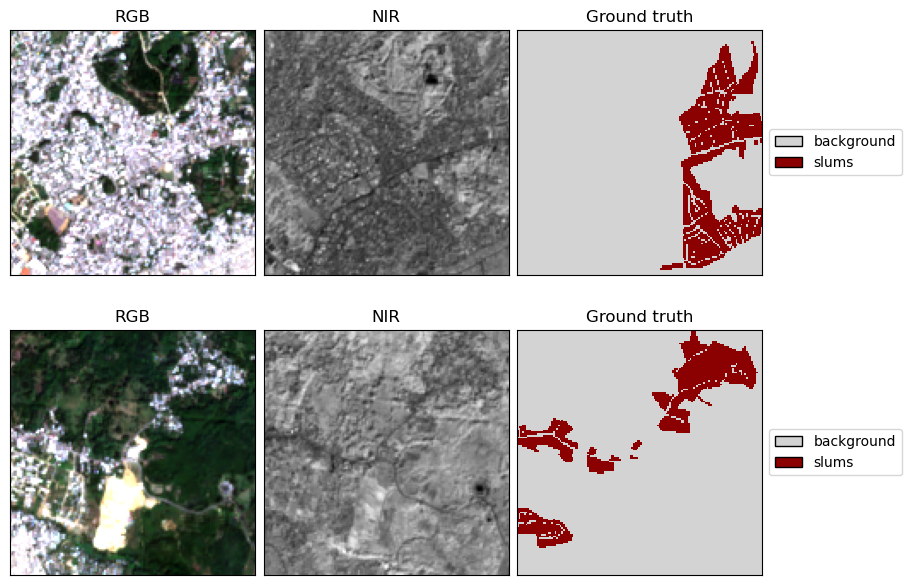

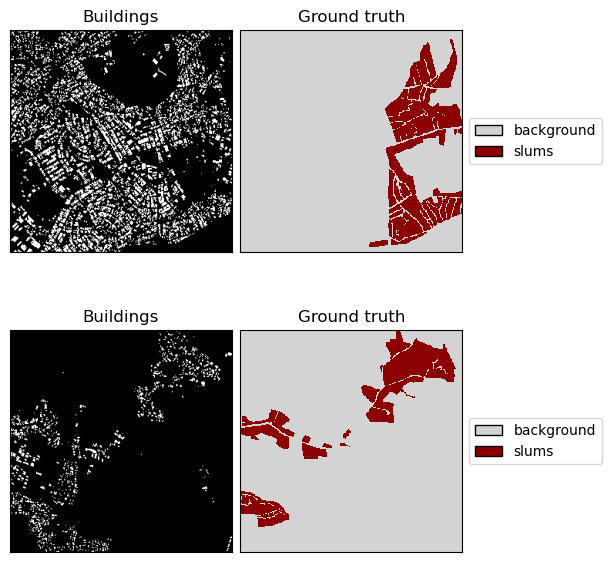

In [11]:
vis_sent = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_sent)

vis_build = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_build)

x, y = vis_sent.get_batch(sentinelGeoDataset_SD, 2)
vis_sent.plot_batch(x, y, show=True)

x, y = vis_build.get_batch(buildingsGeoDataset_SD, 2)
vis_build.plot_batch(x, y, show=True)

In [12]:
class MultiModalDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def setup(self, stage=None):
        pass

# Initialize the data module
data_module = MultiModalDataModule(train_loader, val_loader)

# Train the model

In [13]:
data_module = MultiModalDataModule(train_loader, val_loader)

In [14]:
# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

In [15]:
model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

MultiResolutionDeepLabV3(
  (encoder): IntermediateLayerGetter(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (d

In [16]:
for batch_idx, batch in enumerate(data_module.train_dataloader()):
    # sentinel_batch, buildings_batch = batch
    # buildings_data, buildings_labels = buildings_batch
    # sentinel_data, _ = sentinel_batch
    # sentinel_data = sentinel_data.to(device)
    # buildings_data = buildings_data.to(device)
    out = model(batch)
    print(f"out data shape: {out.shape}")
    break

RuntimeError: stack expects each tensor to be equal size, but got [1, 288, 288] at entry 0 and [4, 144, 144] at entry 3

In [17]:
train_multiple_cities=True

if train_multiple_cities:
    # Guatemala City
    sentinel_source_normalizedGC, sentinel_label_raster_sourceGC = create_sentinel_raster_source(image_uriGC, label_uriGC, class_config, clip_to_label_source=True)
    rasterized_buildings_sourceGC, buildings_label_sourceGC, crs_transformer_buildingsGC = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriGC, class_config, resolution=5)    

    BuildingsScene_GC = Scene(
            id='GC_buildings',
            raster_source = rasterized_buildings_sourceGC,
            label_source = buildings_label_sourceGC)
            
    SentinelScene_GC = Scene(
            id='GC_sentinel',
            raster_source = sentinel_source_normalizedGC,
            label_source = sentinel_label_raster_sourceGC)

    # # Tegucigalpa
    # sentinel_source_normalizedTG, sentinel_label_raster_sourceTG = create_sentinel_raster_source(image_uriGC, label_uriTG, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourceTG, buildings_label_sourceTG, crs_transformer_buildingsTG = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriTG, class_config, resolution=5)

    # SentinelScene_TG = Scene(
    #     id='TG_sentinel',
    #     raster_source=sentinel_source_normalizedTG,
    #     label_source=sentinel_label_raster_sourceTG)

    # BuildingsScene_TG = Scene(
    #     id='TG_buildings',
    #     raster_source=rasterized_buildings_sourceTG,
    #     label_source=buildings_label_sourceTG)

    # # Panama City
    # sentinel_source_normalizedPN, sentinel_label_raster_sourcePN = create_sentinel_raster_source(image_uriPN, label_uriPN, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourcePN, buildings_label_sourcePN, crs_transformer_buildingsPN = create_buildings_raster_source(buildings_uriPN, image_uriPN, label_uriPN, class_config, resolution=5)

    # SentinelScene_PN = Scene(
    #     id='PN_sentinel',
    #     raster_source=sentinel_source_normalizedPN,
    #     label_source=sentinel_label_raster_sourcePN)

    # BuildingsScene_PN = Scene(
    #     id='PN_buildings',
    #     raster_source=rasterized_buildings_sourcePN,
    #     label_source=buildings_label_sourcePN)
    
    # Guatemala City
    buildingsGeoDataset_GC, GBbuiltra, _, _ = create_datasets(BuildingsScene_GC, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    sentinelGeoDataset_GC, GCsenttr, _, _ = create_datasets(SentinelScene_GC, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # Tegucigalpa
    # buildingsGeoDataset_TG, train_buildings_dataset_TG, val_buildings_dataset_TG, test_buildings_dataset_TG = create_datasets(BuildingsScene_TG, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_TG, train_sentinel_dataset_TG, val_sentinel_dataset_TG, test_sentinel_dataset_TG = create_datasets(SentinelScene_TG, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # # Panama City
    # buildingsGeoDataset_PN, train_buildings_dataset_PN, val_buildings_dataset_PN, test_buildings_dataset_PN = create_datasets(BuildingsScene_PN, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_PN, train_sentinel_dataset_PN, val_sentinel_dataset_PN, test_sentinel_dataset_PN = create_datasets(SentinelScene_PN, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, GBbuiltra]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
    all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
    all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

    all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, GCsenttr]) # train_buildings_dataset_TG, train_buildings_dataset_PN
    all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
    all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
        
    train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
    val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

else:
    # when one city for training:
    train_dataset = MergeDataset(train_sentinel_dataset_SD, train_buildings_dataset_SD)
    val_dataset = MergeDataset(val_sentinel_dataset_SD, val_buildings_dataset_SD)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Loaded SemanticSegmentationLabelSource: (2402, 2437, 1)


Analyzing chips: 0it [00:00, ?it/s]

Loaded Sentinel data of size (2402, 2437, 4), and dtype: float64


Transforming to pixel coords:   7%|6         | 47911/691411 [00:05<01:07, 9582.16it/s]

Splitting multi-part geoms:  62%|######1   | 427883/691411 [00:05<00:03, 85576.53it/s]

Simplifying polygons:  13%|#3        | 90386/691433 [00:05<00:33, 18077.01it/s]

Splitting multi-part geoms:  87%|########6 | 581770/669095 [00:05<00:00, 116353.64it/s]

Loaded Rasterised buildings data of size (4804, 4872, 1), and dtype: <class 'numpy.uint8'>
Train dataset length: 180
Validation dataset length: 51
Test (hold-out) dataset length: 25
Train dataset length: 180
Validation dataset length: 51
Test (hold-out) dataset length: 25


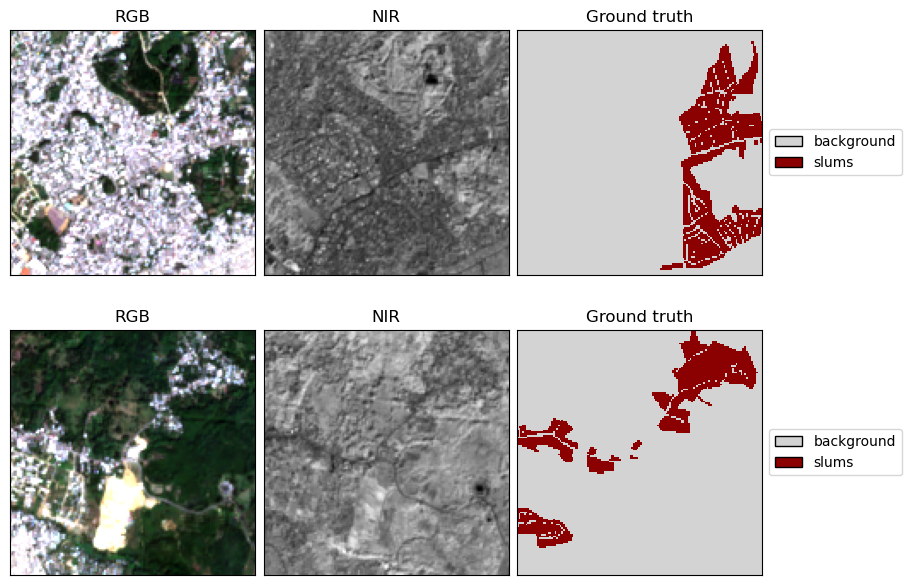

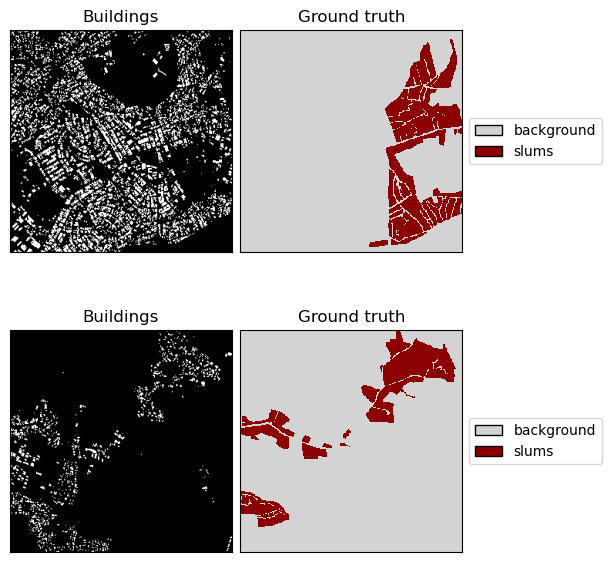

In [18]:
channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

vis_sent = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_sent)

vis_build = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_build)

x, y = vis_sent.get_batch(sentinelGeoDataset_SD, 2)
vis_sent.plot_batch(x, y, show=True)

x, y = vis_build.get_batch(buildingsGeoDataset_SD, 2)
vis_build.plot_batch(x, y, show=True)

In [19]:
class MultiModalDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def setup(self, stage=None):
        pass

# Initialize the data module
data_module = MultiModalDataModule(train_loader, val_loader)

# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

MultiResolutionDeepLabV3(
  (encoder): IntermediateLayerGetter(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (d

In [20]:
for batch_idx, batch in enumerate(data_module.train_dataloader()):
    # sentinel_batch, buildings_batch = batch
    # buildings_data, buildings_labels = buildings_batch
    # sentinel_data, _ = sentinel_batch
    # sentinel_data = sentinel_data.to(device)
    # buildings_data = buildings_data.to(device)
    out = model(batch)
    print(f"out data shape: {out.shape}")
    break

RuntimeError: stack expects each tensor to be equal size, but got [1, 288, 288] at entry 0 and [4, 144, 144] at entry 5

In [ ]:
output_dir = f'../UNITAC-trained-models/multi_modal/SD_DLV3/'
os.makedirs(output_dir, exist_ok=True)

wandb.init(project='UNITAC-multi-modal', config=hyperparameters)
wandb_logger = WandbLogger(project='UNITAC-multi-modal', log_model=True)

# Loggers and callbacks
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=output_dir,
    filename='multimodal_runid{run_id}-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=50)

# Define trainer
trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
    logger=[wandb_logger],
    min_epochs=20,
    max_epochs=150,
    num_sanity_val_steps=3
)

# Train the model
trainer.fit(model, datamodule=data_module)

: 

In [21]:
best_model_path_dplv3 = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_DLV3/multimodal_runidrun_id=0-batch_size=00-epoch=01-val_loss=435412992.0000.ckpt"

In [22]:
best_model_path_dplv3 = checkpoint_callback.best_model_path

In [23]:
best_model = MultiResolutionDeepLabV3.load_from_checkpoint(best_model_path_dplv3) #MultiResolutionDeepLabV3 MultiResolutionFPN

IsADirectoryError: [Errno 21] Is a directory: '/Users/janmagnuszewski/dev/slums-model-unitac/src/models'

In [24]:
best_model.eval()

NameError: name 'best_model' is not defined

In [25]:
best_model_path_dplv3 = "/Users/janmagnuszewski/dev/slums-model-unitac/src/UNITAC-trained-models/multi_modal/SD_DLV3/multimodal_runidrun_id=0-batch_size=00-epoch=01-val_loss=435412992.0000.ckpt"

In [26]:
best_model_path_dplv3 = checkpoint_callback.best_model_path

In [27]:
best_model = MultiResolutionDeepLabV3.load_from_checkpoint(best_model_path_dplv3) #MultiResolutionDeepLabV3 MultiResolutionFPN

IsADirectoryError: [Errno 21] Is a directory: '/Users/janmagnuszewski/dev/slums-model-unitac/src/models'

Train dataset length: 71
Validation dataset length: 19
Test (hold-out) dataset length: 9
Train dataset length: 71
Validation dataset length: 19
Test (hold-out) dataset length: 9


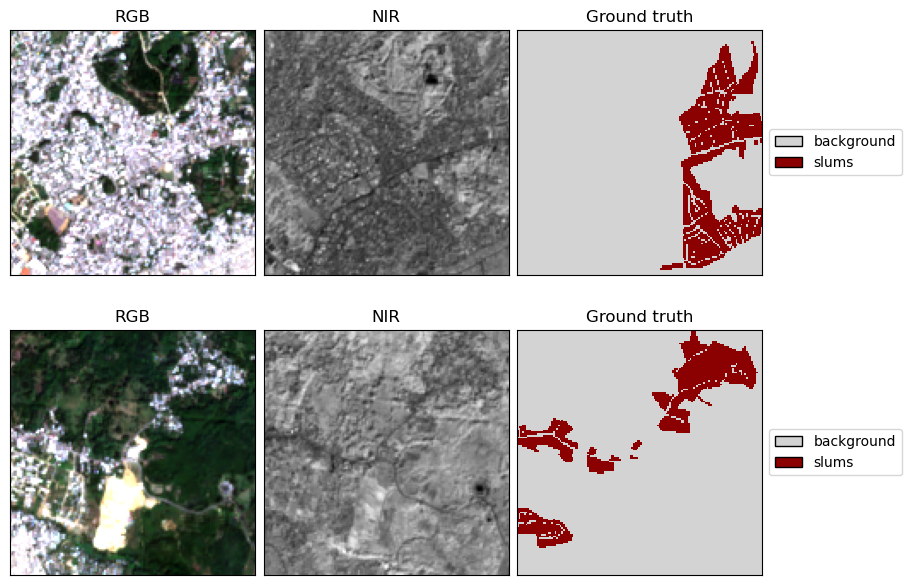

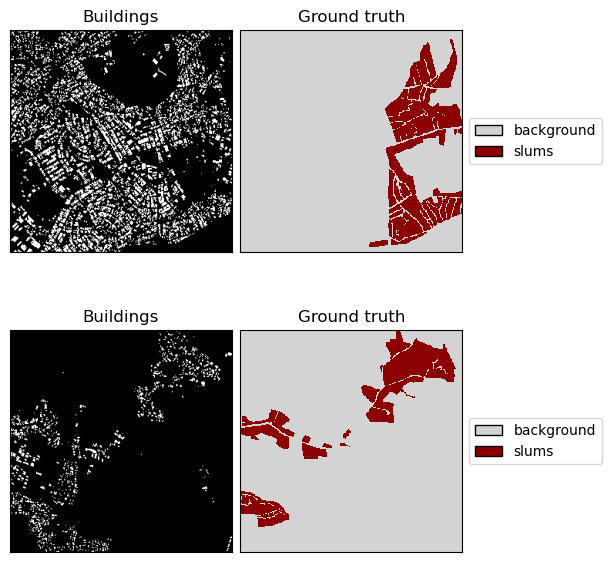

out data shape: torch.Size([16, 288, 288])


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type                    | Params | Mode 
----------------------------------------------------------------------
0 | encoder           | IntermediateLayerGetter | 23.5 M | train
1 | bconv1            | Conv2d                  | 3.1 K  | train
2 | bconv2            | Conv2d                  | 576    | train
3 | segmentation_head | DeepLabHead             | 16.1 M | train
----------------------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.575   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [28]:
SentinelScene_SD = Scene(
        id='santodomingo_sentinel',
        raster_source = sentinel_source_normalizedSD,
        label_source = sentinel_label_raster_sourceSD)
        # aoi_polygons=[pixel_polygon])

BuildingsScene_SD = Scene(
        id='santodomingo_buildings',
        raster_source = rasterized_buildings_sourceSD,
        label_source = buildings_label_sourceSD)

buildingsGeoDataset_SD, train_buildings_dataset_SD, val_buildings_dataset_SD, test_buildings_dataset_SD = create_datasets(BuildingsScene_SD, imgsize=288, stride=288, padding=50, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset_SD, train_sentinel_dataset_SD, val_sentinel_dataset_SD, test_sentinel_dataset_SD = create_datasets(SentinelScene_SD, imgsize=144, stride=144, padding=25, val_ratio=0.2, test_ratio=0.1, seed=42)

batch_size = 16

train_multiple_cities=False

if train_multiple_cities:
    # Guatemala City
    sentinel_source_normalizedGC, sentinel_label_raster_sourceGC = create_sentinel_raster_source(image_uriGC, label_uriGC, class_config, clip_to_label_source=True)
    rasterized_buildings_sourceGC, buildings_label_sourceGC, crs_transformer_buildingsGC = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriGC, class_config, resolution=5)    

    BuildingsScene_GC = Scene(
            id='GC_buildings',
            raster_source = rasterized_buildings_sourceGC,
            label_source = buildings_label_sourceGC)
            
    SentinelScene_GC = Scene(
            id='GC_sentinel',
            raster_source = sentinel_source_normalizedGC,
            label_source = sentinel_label_raster_sourceGC)

    # # Tegucigalpa
    # sentinel_source_normalizedTG, sentinel_label_raster_sourceTG = create_sentinel_raster_source(image_uriGC, label_uriTG, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourceTG, buildings_label_sourceTG, crs_transformer_buildingsTG = create_buildings_raster_source(buildings_uriGC, image_uriGC, label_uriTG, class_config, resolution=5)

    # SentinelScene_TG = Scene(
    #     id='TG_sentinel',
    #     raster_source=sentinel_source_normalizedTG,
    #     label_source=sentinel_label_raster_sourceTG)

    # BuildingsScene_TG = Scene(
    #     id='TG_buildings',
    #     raster_source=rasterized_buildings_sourceTG,
    #     label_source=buildings_label_sourceTG)

    # # Panama City
    # sentinel_source_normalizedPN, sentinel_label_raster_sourcePN = create_sentinel_raster_source(image_uriPN, label_uriPN, class_config, clip_to_label_source=True)
    # rasterized_buildings_sourcePN, buildings_label_sourcePN, crs_transformer_buildingsPN = create_buildings_raster_source(buildings_uriPN, image_uriPN, label_uriPN, class_config, resolution=5)

    # SentinelScene_PN = Scene(
    #     id='PN_sentinel',
    #     raster_source=sentinel_source_normalizedPN,
    #     label_source=sentinel_label_raster_sourcePN)

    # BuildingsScene_PN = Scene(
    #     id='PN_buildings',
    #     raster_source=rasterized_buildings_sourcePN,
    #     label_source=buildings_label_sourcePN)
    
    # Guatemala City
    buildingsGeoDataset_GC, GBbuiltra, _, _ = create_datasets(BuildingsScene_GC, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    sentinelGeoDataset_GC, GCsenttr, _, _ = create_datasets(SentinelScene_GC, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # Tegucigalpa
    # buildingsGeoDataset_TG, train_buildings_dataset_TG, val_buildings_dataset_TG, test_buildings_dataset_TG = create_datasets(BuildingsScene_TG, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_TG, train_sentinel_dataset_TG, val_sentinel_dataset_TG, test_sentinel_dataset_TG = create_datasets(SentinelScene_TG, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    # # Panama City
    # buildingsGeoDataset_PN, train_buildings_dataset_PN, val_buildings_dataset_PN, test_buildings_dataset_PN = create_datasets(BuildingsScene_PN, imgsize=288, stride=288, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
    # sentinelGeoDataset_PN, train_sentinel_dataset_PN, val_sentinel_dataset_PN, test_sentinel_dataset_PN = create_datasets(SentinelScene_PN, imgsize=144, stride=144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)

    all_cities_sentinel_train_ds = ConcatDataset([train_sentinel_dataset_SD, GBbuiltra]) # train_sentinel_dataset_TG, train_sentinel_dataset_PN
    all_cities_sentinel_val_ds = ConcatDataset([val_sentinel_dataset_SD]) # val_sentinel_dataset_GC, val_sentinel_dataset_TG, val_sentinel_dataset_PN
    all_cities_sentinel_test_ds = ConcatDataset([test_sentinel_dataset_SD]) # test_sentinel_dataset_GC, test_sentinel_dataset_TG, test_sentinel_dataset_PN

    all_cities_build_train_ds = ConcatDataset([train_buildings_dataset_SD, GCsenttr]) # train_buildings_dataset_TG, train_buildings_dataset_PN
    all_cities_build_val_ds = ConcatDataset([val_buildings_dataset_SD]) #val_buildings_dataset_GC, val_buildings_dataset_TG, val_buildings_dataset_PN
    all_cities_build_test_ds = ConcatDataset([test_buildings_dataset_SD]) #test_buildings_dataset_GC, test_buildings_dataset_TG, test_buildings_dataset_PN
        
    train_dataset = MergeDataset(all_cities_sentinel_train_ds, all_cities_build_train_ds)
    val_dataset = MergeDataset(all_cities_sentinel_val_ds, all_cities_build_val_ds)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

else:
    # when one city for training:
    train_dataset = MergeDataset(train_sentinel_dataset_SD, train_buildings_dataset_SD)
    val_dataset = MergeDataset(val_sentinel_dataset_SD, val_buildings_dataset_SD)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

channel_display_groups_sent = {'RGB': (0,1,2), 'NIR': (3, )}
channel_display_groups_build = {'Buildings': (0,)}

vis_sent = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_sent)

vis_build = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups_build)

x, y = vis_sent.get_batch(sentinelGeoDataset_SD, 2)
vis_sent.plot_batch(x, y, show=True)

x, y = vis_build.get_batch(buildingsGeoDataset_SD, 2)
vis_build.plot_batch(x, y, show=True)

class MultiModalDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def setup(self, stage=None):
        pass

# Initialize the data module
data_module = MultiModalDataModule(train_loader, val_loader)

# Train the model
class MultiResolutionDeepLabV3(pl.LightningModule):
    def __init__(self,
                use_deeplnafrica: bool = True,
                learning_rate: float = 1e-2,
                weight_decay: float = 1e-1,
                gamma: float = 0.1,
                atrous_rates = (6, 12, 24),
                sched_step_size = 10,
                pos_weight: torch.Tensor = torch.tensor(1.0, device='mps')):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.atrous_rates = atrous_rates
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.sched_step_size = sched_step_size
        
        self.encoder = deeplabv3_resnet50(pretrained=False, progress=False, num_classes=1)     
        
        # self.bconv1 = nn.Conv2d(1, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.bconv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), bias=False)
        self.bconv2 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        
        self.encoder.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        if use_deeplnafrica:
            allcts_path = '/Users/janmagnuszewski/dev/slums-model-unitac/deeplnafrica/deeplnafrica_trained_models/all_countries/TAN_KEN_SA_UGA_SIE_SUD/checkpoints/best-val-epoch=44-step=1035-val_loss=0.2.ckpt'
            checkpoint = torch.load(allcts_path, map_location='cpu')  # Load to CPU first
            original_state_dict = checkpoint["state_dict"]

            # Convert any float64 weights to float32
            for key, value in original_state_dict.items():
                if value.dtype == torch.float64:
                    original_state_dict[key] = value.to(torch.float32)
                    
            # removing prefix
            state_dict = OrderedDict()
            for key, value in original_state_dict.items():
                if key.startswith('segm_model.backbone.'):
                    new_key = key[len('segm_model.backbone.'):]
                    state_dict[new_key] = value

            # Extract the original weights of the first convolutional layer
            original_conv1_weight = state_dict['conv1.weight']
            new_conv1_weight = torch.zeros((64, 5, 7, 7))
            new_conv1_weight[:, :4, :, :] = original_conv1_weight
            new_conv1_weight[:, 4, :, :] = original_conv1_weight[:, 0, :, :]
            new_conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            new_conv1.weight = nn.Parameter(new_conv1_weight)
            new_state_dict = state_dict.copy()
            new_state_dict['conv1.weight'] = new_conv1.weight

            self.encoder.backbone.load_state_dict(new_state_dict, strict=True)
        
        # Intermediate Layer Getter
        self.encoder = IntermediateLayerGetter(self.encoder.backbone, {'layer4': 'out'})#, 'layer3': 'layer3','layer2': 'layer2','layer1': 'layer1'})
        self.segmentation_head = DeepLabHead(in_channels=2048, num_classes=1, atrous_rates=self.atrous_rates)
           
    def forward(self, batch):

        sentinel_batch, buildings_batch = batch
        buildings_data, buildings_labels = buildings_batch
        sentinel_data, _ = sentinel_batch
        
        # Move data to the device
        sentinel_data = sentinel_data.to(self.device)
        buildings_data = buildings_data.to(self.device)
        buildings_labels = buildings_labels.to(self.device)
        
        b_out1 = self.bconv1(buildings_data)
        b_out2 = self.bconv2(b_out1)
        
        concatenated = torch.cat([sentinel_data, b_out2], dim=1)    
        # print(concatenated.shape, "concatenated shape")
        out = self.encoder(concatenated)
        out = out['out']

        segmentation = self.segmentation_head(out)
        
        segmentation = F.interpolate(segmentation, size=288, mode="bilinear", align_corners=False)
        
        return segmentation.squeeze(1)
    
    def training_step(self, batch):
        
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)
        
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('train_loss', loss)
        self.log('train_mean_iou', mean_iou)
        self.log('train_precision', mean_precision)
        self.log('train_recall', mean_recall)
                
        return loss
    
    def validation_step(self, batch):
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)      
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        val_loss = loss_fn(segmentation, buildings_labels.float())
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)
        
        self.log('val_mean_iou', mean_iou)
        self.log('val_loss', val_loss, prog_bar=True, logger=True)
        self.log('val_precision', mean_precision)
        self.log('val_recall', mean_recall)
    
    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]) -> None:
        _, buildings_batch = batch
        _, buildings_labels = buildings_batch

        segmentation = self.forward(batch)     
        assert segmentation.shape == buildings_labels.shape, f"Shapes mismatch: {segmentation.shape} vs {buildings_labels.shape}"

        loss_fn = torch.nn.BCEWithLogitsLoss()
        test_loss = loss_fn(segmentation, buildings_labels)
        
        preds = torch.sigmoid(segmentation) > 0.5
        mean_iou, mean_precision, mean_recall = self.compute_metrics(preds, buildings_labels)

        self.log('test_loss', test_loss)
        self.log('test_mean_iou', mean_iou)
        self.log('test_precision', mean_precision)
        self.log('test_recall', mean_recall)
        
    def compute_metrics(self, preds, target):
        preds = preds.bool()
        target = target.bool()
        smooth = 1e-6
        
        # IoU computation
        intersection = (preds & target).float().sum((1, 2))
        union = (preds | target).float().sum((1, 2))
        iou = (intersection + smooth) / (union + smooth)
        mean_iou = iou.mean()
        
        # Precision and Recall computation
        true_positives = (preds & target).sum((1, 2))
        predicted_positives = preds.sum((1, 2))
        actual_positives = target.sum((1, 2))
        
        precision = true_positives.float() / (predicted_positives.float() + 1e-10)
        recall = true_positives.float() / (actual_positives.float() + 1e-10)
        
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        
        return mean_iou, mean_precision, mean_recall

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.sched_step_size,  # adjust step_size to your needs
            gamma=self.gamma      # adjust gamma to your needs
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

hyperparameters = {
    'model': 'DLV3',
    'use_deeplnafrica': True,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'gamma': 1,
    'sched_step_size': 50,
    'pos_weight': 1.0,
}

model = MultiResolutionDeepLabV3(
    use_deeplnafrica=hyperparameters['use_deeplnafrica'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    gamma=hyperparameters['gamma'],
    sched_step_size=hyperparameters['sched_step_size'],
    pos_weight=torch.tensor(hyperparameters['pos_weight'], device='mps')
)
model.to(device)

for batch_idx, batch in enumerate(data_module.train_dataloader()):
    # sentinel_batch, buildings_batch = batch
    # buildings_data, buildings_labels = buildings_batch
    # sentinel_data, _ = sentinel_batch
    # sentinel_data = sentinel_data.to(device)
    # buildings_data = buildings_data.to(device)
    out = model(batch)
    print(f"out data shape: {out.shape}")
    break

output_dir = f'../UNITAC-trained-models/multi_modal/SD_DLV3/'
os.makedirs(output_dir, exist_ok=True)

wandb.init(project='UNITAC-multi-modal', config=hyperparameters)
wandb_logger = WandbLogger(project='UNITAC-multi-modal', log_model=True)

# Loggers and callbacks
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=output_dir,
    filename='multimodal_runid{run_id}-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=100)

# Define trainer
trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
    logger=[wandb_logger],
    min_epochs=50,
    max_epochs=500,
    num_sanity_val_steps=3
)

# Train the model
trainer.fit(model, datamodule=data_module)

Train dataset length: 251
Validation dataset length: 71
Test (hold-out) dataset length: 35
Train dataset length: 251
Validation dataset length: 71
Test (hold-out) dataset length: 35


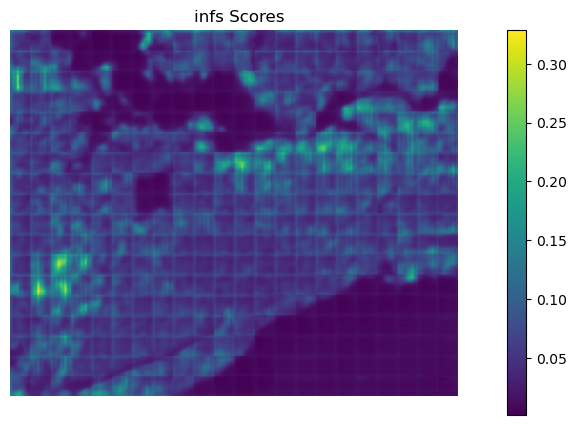

In [29]:
best_model_path_dplv3 = checkpoint_callback.best_model_path
best_model = MultiResolutionDeepLabV3.load_from_checkpoint(best_model_path_dplv3) #MultiResolutionDeepLabV3 MultiResolutionFPN
best_model.eval()

buildingsGeoDataset, train_buildings_dataset, val_buildings_dataset, test_buildings_dataset = create_datasets(BuildingsScene_SD, imgsize=288, stride = 144, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
sentinelGeoDataset, train_sentinel_dataset, val_sentinel_dataset, test_sentinel_dataset = create_datasets(SentinelScene_SD, imgsize=144, stride = 72, padding=0, val_ratio=0.2, test_ratio=0.1, seed=42)
predictions_iterator = MultiModalPredictionsIterator(best_model, sentinelGeoDataset, buildingsGeoDataset, device=device)
windows, predictions = zip(*predictions_iterator)

# Ensure windows are Box instances
windows = [Box(*window.tolist()) if isinstance(window, torch.Tensor) else window for window in windows]

# Create SemanticSegmentationLabels from predictions
pred_labels = SemanticSegmentationLabels.from_predictions(
    windows,
    predictions,
    extent=BuildingsScene_SD.extent,
    num_classes=len(class_config),
    smooth=True
)

# Show predictions
scores = pred_labels.get_score_arr(pred_labels.extent)
scores_building = scores[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
image = ax.imshow(scores_building)
ax.axis('off')
ax.set_title('infs Scores')
cbar = fig.colorbar(image, ax=ax)
plt.show()

In [30]:
class_config = ClassConfig(names=['background', 'slums'], 
                                colors=['lightgray', 'darkred'],
                                null_class='background')

con = duckdb.connect("../../data/0/data.db")

con.install_extension('httpfs')
con.install_extension('spatial')
con.load_extension('httpfs')
con.load_extension('spatial')
con.execute("SET s3_region='us-west-2'")
con.execute("SET azure_storage_connection_string = 'DefaultEndpointsProtocol=https;AccountName=overturemapswestus2;AccountKey=;EndpointSuffix=core.windows.net';")

sica_cities = "/Users/janmagnuszewski/dev/slums-model-unitac/data/0/SICA_cities.parquet"
gdf = gpd.read_parquet(sica_cities)
gdf = gdf.to_crs('EPSG:3857')

IOException: IO Error: Could not set lock on file "/Users/janmagnuszewski/dev/slums-model-unitac/src/models/../../data/0/data.db": Conflicting lock is held in /opt/miniconda3/envs/rv/bin/python3.11 (PID 96925) by user janmagnuszewski. See also https://duckdb.org/docs/connect/concurrency

In [ ]:
for index, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
    city_name = row['city_ascii']
    country_code = row['iso3']
    print("Doing predictions for: ", city_name, country_code)
    image_uri =  f"../../data/0/sentinel_Gee/{country_code}_{city_name}_2023.tif"
    
    # Check if the image_uri exists
    if not os.path.exists(image_uri):
        print(f"Warning: File {image_uri} does not exist. Skipping to next row.")
        continue
    
    gdf_xmin, gdf_ymin, gdf_xmax, gdf_ymax = row['geometry'].bounds
    
    try:
        with rasterio.open(image_uri) as src:
            bounds = src.bounds
            raster_xmin, raster_ymin, raster_xmax, raster_ymax = bounds.left, bounds.bottom, bounds.right, bounds.top
            
    except Exception as e:
        print(f"Error processing {image_uri}: {e}")
        continue
    
    # Define the common box in EPSG:3857
    common_xmin_3857 = max(gdf_xmin, raster_xmin)
    common_ymin_3857 = max(gdf_ymin, raster_ymin)
    common_xmax_3857 = min(gdf_xmax, raster_xmax)
    common_ymax_3857 = min(gdf_ymax, raster_ymax)

    transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    common_xmin_4326, common_ymin_4326 = transformer.transform(common_xmin_3857, common_ymin_3857)
    common_xmax_4326, common_ymax_4326 = transformer.transform(common_xmax_3857, common_ymax_3857)
    print("Got common extent for: ", city_name, country_code)
    
    buildings = query_buildings_data(con, common_xmin_4326, common_ymin_4326, common_xmax_4326, common_ymax_4326)
    print("Got buildings extent for: ", city_name, country_code)

    rasterized_buildings_source, buildings_extent, crs_transformer_buildings = rasterise_buildings(image_uri, buildings, common_xmin_3857, common_ymax_3857)

    sentinel_source = get_sentinel_source(image_uri, buildings_extent)
    
    buil_ds, sent_ds, build_scene = build_datasets(rasterized_buildings_source, sentinel_source)
    print("Got datasets extent for: ", city_name, country_code)

    save_predictions(best_model, sent_ds, buil_ds, build_scene, crs_transformer_buildings, country_code, city_name)
    print(f"Saved predictions data for {city_name}, {country_code}")
    
# # Merge geojson for cities
# de

: 